In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.optimize import curve_fit

## Define Functions

In [2]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def cost_of_perturbation(W, W_prime, discount_function, gamma=2, D0=0.00267):
    absolute_consumption_loss = W-W_prime
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = simps(discounted_consumption_loss, dx=1)
    cost = area*10**12  # convert to dollar amount
    
    return cost

In [3]:
## calculate abatement given a carbon price

## default settings
# P_50 = 300  # 187.5 * 0.7625000000000001
# P_100 = 500  # 187.5
# g_2019 = 0.02
# g_grad = 0.0004  # 0.00034
# W_2019 = 80
# consumption_discount = g_2019 + 0.015
# s = 0.05
# r = 0.04

## test 
# P_50 = 112.5 * 0.6375
# P_100 = 112.5 
# g_2019 = 0.02
# g_grad = 0.0004  # g_grad = 0.0004
# W_2019 = 80
# consumption_discount = g_2019 + 0.015
# constraint = 2.5  # param_values_2[i][1]
# r = consumption_discount
# s = r * np.log(constraint)/np.log((P_100)/(P_50))
P_50 = 100  # 187.5 * 0.7625000000000001
P_100 = 500  # 187.5
g_2019 = 0.02
g_grad = 0.0013 # 0.00034
W_2019 = 80
consumption_discount = g_2019 + 0.015
# s = 0.05
r = 0.04
P0_prime = 20
s = 0.1


def abatement(P, P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

In [4]:
## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

In [5]:
def create_W(W_2019, last_historical_year, start_year, T_forecast_years, g):
    W = []
    W_historical = [W_2019] * (last_historical_year - start_year + 1)
    W_forecast = []
    W_previous_year = W_historical[-1]

    for i in range(len(T_forecast_years) - 1):
        W_this_year = W_previous_year*np.exp(g[i])
        W_forecast.append(W_this_year)
        W_previous_year = W_this_year

    W = W_historical + W_forecast

    W = np.asarray(W)
    return W

# Steps outlined in Email

## 1. Create Unperturbed Temperature Profile

In [6]:
# get historical data (taken from chrisroadmap)

T_gas_df = pd.read_csv("T_gas.csv", index_col=0)

T_2019 = T_gas_df['CO2_best'][2019]

In [7]:
start_year = 1750
last_historical_year = 2019
end_year = 3000

years = np.arange(start_year, end_year+1)
T_forecast_years = np.arange(last_historical_year, end_year+1)
T_forecast_length = end_year - last_historical_year + 1

In [8]:
delta_T = 1
alpha = 0.02
T_forecast = T_2019 + delta_T * (1 - np.exp(-alpha*np.arange(T_forecast_length)))

In [9]:
T = np.concatenate([T_gas_df['CO2_best'],T_forecast[1:]])

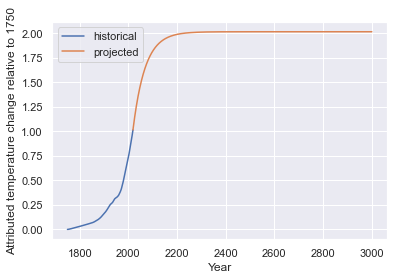

In [10]:
plt.plot(T_gas_df['CO2_best'], label="historical")
plt.plot(T_forecast_years, T_forecast, label="projected")
plt.xlabel("Year")
plt.ylabel("Attributed temperature change relative to 1750")
plt.legend()

## 2. Calculate SCC as a function of time for a range of years

In [11]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2500
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)


SCC_list = []

for j in range(len(year_of_perturbation)):
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00054  # need to check this for FAIR!
    k_s = 0.12

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])
    

    g = g_2019 - g_grad*(T_forecast[:-1]-T_2019)**1
    g_prime = g_2019 - g_grad*(T_forecast_perturbed[:-1]-T_2019)**1
    

    W = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g)
    W_prime = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g_prime)

    ## define discount function
    num_of_years = len(years)
    discount_function = np.zeros(num_of_years)

    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
    
    cost = cost_of_perturbation(W, W_prime, discount_function, gamma=2, D0=0.00267)
    SCC = cost/(10**9)
    
    if j == 0 and SCC > P_100:
        print("P_100 achieved in first year")
        print(SCC)
    elif SCC < P_100:
        SCC_list.append(SCC)
#         print(SCC)
    else:
        SCC_list.append(P_100)
        break

In [12]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

In [13]:
SCC_array

array([194.83858425, 198.56013618, 202.35304475, 206.21634125,
       210.15371583, 214.16415701, 218.25150148, 222.41469331,
       226.65772133, 230.97948349, 235.38412652, 239.87050052,
       244.44291613, 249.10017376, 253.84675423, 258.68140637,
       263.60878763, 268.62759331, 273.74266423, 278.95264011,
       284.26255213, 289.67098231, 295.18315945, 300.79760567,
       306.5197549 , 312.34806711, 318.28818915, 324.33851647,
       330.50491698, 336.78571915, 343.18702033, 349.70707947,
       356.35223216, 363.12066514, 370.01896127, 377.0452324 ,
       384.20631806, 391.50025236, 398.93414128, 406.50593818,
       414.22302569, 422.08327338, 430.09435101, 438.25404118,
       446.57031173, 455.04085495, 463.67394813, 472.46718987,
       481.42917862, 490.55741572, 499.8608331 , 500.        ])

Text(0, 0.5, 'SCC ($)')

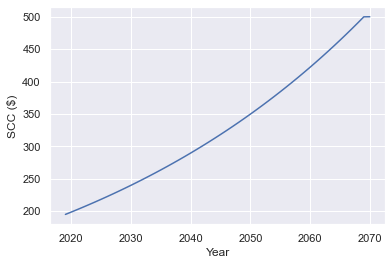

In [14]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [15]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

In [16]:
SCC_forecasted = []

for i in range(T_forecast_length):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [17]:
# SCC_forecasted

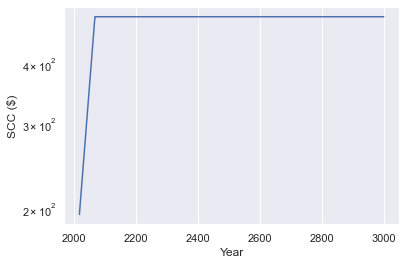

In [18]:
plt.plot(T_forecast_years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [19]:
P0 = SCC_forecasted[0]

In [20]:
# P0

In [21]:
forecasted_abatement = abatement(P=SCC_forecasted-(P0-P0_prime), P0=P0_prime)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_73238/3915375078.py:44: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


In [22]:
forecasted_abatement

array([0.00000000e+00, 4.61247514e-04, 2.66636863e-03, 7.48579331e-03,
       1.56088323e-02, 2.75833183e-02, 4.38254285e-02, 6.45670206e-02,
       8.98743729e-02, 1.19586482e-01, 1.53380304e-01, 1.90719259e-01,
       2.30970895e-01, 2.73363445e-01, 3.17135147e-01, 3.61481781e-01,
       4.05706025e-01, 4.49141922e-01, 4.91282641e-01, 5.31682702e-01,
       5.70059590e-01, 6.06185960e-01, 6.39970804e-01, 6.71355169e-01,
       7.00380008e-01, 7.27093982e-01, 7.51612513e-01, 7.74040668e-01,
       7.94525343e-01, 8.13192631e-01, 8.30193741e-01, 8.45654732e-01,
       8.59716422e-01, 8.72494091e-01, 8.84111708e-01, 8.94669492e-01,
       9.04272946e-01, 9.13006562e-01, 9.20958274e-01, 9.28197976e-01,
       9.34798026e-01, 9.40815582e-01, 9.46309742e-01, 9.51326933e-01,
       9.55915239e-01, 9.60112239e-01, 9.63957005e-01, 9.67479915e-01,
       9.70712726e-01, 9.73680008e-01, 9.76407609e-01, 9.76446328e-01,
       9.76446328e-01, 9.76446328e-01, 9.76446328e-01, 9.76446328e-01,
      

problems with certain values due to constraints of the model

In [39]:
((P_100-P0)/(P_50-P0))**(s/r)

88.18163074019441

Text(0, 0.5, 'Abatement')

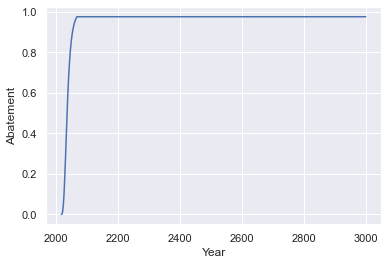

In [24]:
plt.plot(T_forecast_years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [25]:
ssp_df = pd.read_csv("ssp245.csv", index_col=0)

In [26]:
ssp245_CO2_past = ssp_df["carbon_dioxide"]*(44/12)  

In [27]:
CO2_baseline = ssp245_CO2_past[2019] # set baseline to current emissions

In [28]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

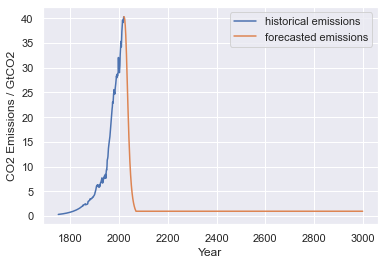

In [29]:
plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(T_forecast_years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

## 5. Cumulative Emissions to Temperature Change

In [30]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [31]:
temperature_change = T_TCRE*cumulative_emissions_array

In [32]:
T_forecast_iteration0 = T_2019 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

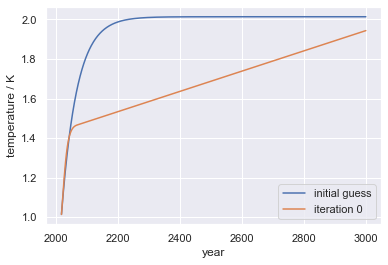

In [33]:
plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [34]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [35]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_73238/3915375078.py:44: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_73238/3915375078.py:44: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


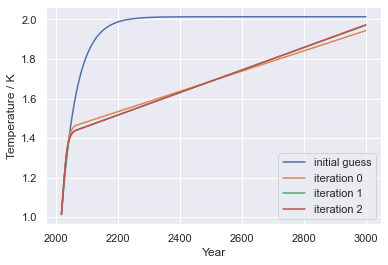

In [36]:
num_of_iterations = 99

first_perturbed_year = last_historical_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
    T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []

    for j in range(len(year_of_perturbation)):
        ## define perturbation
        T_TCRE = 0.00054  # need to check this! *100 for 100GtCO2 added
        k_s = 0.12

        T_p = np.zeros(T_forecast_length)

        for i in range(len(T_forecast_years)):
            if year_of_perturbation[j] <= T_forecast_years[i]:
                T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))

        T_forecast_perturbed = T_forecast_iteration+T_p

        T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

        g = g_2019 - g_grad*(T_forecast_iteration[:-1]-T_2019)**1
        g_prime = g_2019 - g_grad*(T_forecast_perturbed[:-1]-T_2019)**1
        
        
        W = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g)
        W_prime = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g_prime)

        ## define discount function
        num_of_years = len(years)

        discount_function = np.zeros(num_of_years)

        for i in range(num_of_years):
            if years[i] >= year_of_perturbation[j]:
                discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))

        absolute_consumption_loss = W-W_prime
        discounted_consumption_loss = absolute_consumption_loss*discount_function
        area = simps(discounted_consumption_loss, dx=1)
        cost = area*10**12  # convert to dollar amount
        
        SCC = cost/(10**9)
        
        if SCC < P_100:
            SCC_list.append(SCC)
        else:
            SCC_list.append(P_100)
            break

    SCC_array = np.asarray(SCC_list)

    SCC_forecasted = []

    for i in range(T_forecast_length):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted-(P0-P0_prime), P0=P0_prime)  # , r=consumption_discount
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE*cumulative_emissions_array
    
    T_forecast_iteration = T_2019 + temperature_change
    
    plt.plot(T_forecast_years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = max(T_forecast_iteration)
    else:
        previous_peak_T = peak_T
        peak_T = max(T_forecast_iteration)
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{g_2019=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

In [37]:
P0

204.08912471002859

In [38]:
## peak Temperature
max(T_forecast_iteration)

1.9730648290138288

hard constraint on absolute reduction that can be achieved in one year

- max ~2GtCO2 in year (look in IAMs)
- directions MACC non...
- comment on efficiency
- equation on flowchart
- balance between forcing log and errors
- gradient MACC
- table for Sobol
- peak warming and year of peak warming; scatter with growth rate